In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch_dct as dct

from lib.tools import *
from lib.jpeg import *
from lib.decomposition import *
from lib.regression import *
from lib.sketchml import *

# Low rank tensor

In [2]:
tensor_shape = (3,128,128)
tensor_size  = 128*128*3
rank = 3

In [3]:
# CP decomposition: Creating factor matrices for the tensor
tensor = torch.zeros(tensor_shape)
for i in range(tensor_shape[0]):
    factor_1 = torch.randn(tensor_shape[1], rank)
    factor_2 = torch.randn(tensor_shape[2], rank)
    tensor_slice = torch.einsum('ir,jr->ij', factor_1, factor_2)
    tensor[i] = tensor_slice

In [4]:
# manipulate the tensor
# value_mask = abs(tensor)>0.001
# tensor = tensor* value_mask

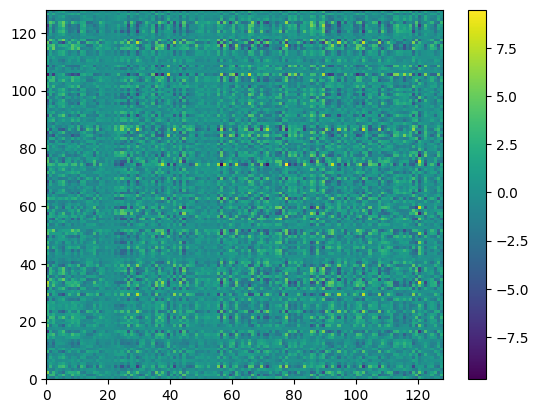

In [5]:
plot_tensor = tensor.reshape([3,128,128])
plt.figure()
plt.pcolormesh(plot_tensor[0])
plt.colorbar()

## Get tensor charateristics

In [6]:
actual_rank= calculate_slice_avg_rank(tensor.reshape(3,128,128))
print("The acutal rank of the tensor is: ", actual_rank)

The acutal rank of the tensor is:  3.0


In [7]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.0


## Tensor compression

#### Jpeg

In [8]:
lowrank_jpeg_ratio = []
lowrank_jpeg_snr =[]
lowrank_jpeg_mse = []

In [9]:
for i in range(10):
    tensor_j = tensor.reshape([128,128,3])
    jpeg_quality = 55 + i *5
    normalize_base, scale,zero_point, encoded_data, compressed_size_jpeg = compressor_jpeg(tensor_j, jpeg_quality)
    print("Compressed size: ", compressed_size_jpeg)

    reconstructed_tensor_jpeg = decompressor_jpeg(tensor_j.shape,normalize_base, scale,zero_point, encoded_data )
    snr_jpeg = calculate_snr(tensor_size,tensor_j.numpy(), reconstructed_tensor_jpeg.numpy())
    mse_jpeg = calculate_mse(tensor_j.numpy(), reconstructed_tensor_jpeg.numpy())
    print("Reconstruction snr (dB): ", snr_jpeg)
    print("Reconstruction mse: ", mse_jpeg)
    
    lowrank_jpeg_ratio.append((tensor_size*4) / compressed_size_jpeg)
    lowrank_jpeg_snr.append(snr_jpeg)
    lowrank_jpeg_mse.append(mse_jpeg / torch.max(tensor_j).item())

Compressed size:  4910
Reconstruction snr (dB):  0.9257116913795471
Reconstruction mse:  2.418022
Compressed size:  5630
Reconstruction snr (dB):  1.1272438615560532
Reconstruction mse:  2.3083785
Compressed size:  6700
Reconstruction snr (dB):  1.4149735867977142
Reconstruction mse:  2.1603994
Compressed size:  7941
Reconstruction snr (dB):  1.9172725081443787
Reconstruction mse:  1.9244391
Compressed size:  9283
Reconstruction snr (dB):  2.587743103504181
Reconstruction mse:  1.6491383
Compressed size:  11146
Reconstruction snr (dB):  3.7499642372131348
Reconstruction mse:  1.2619292
Compressed size:  13650
Reconstruction snr (dB):  5.586808919906616
Reconstruction mse:  0.826705
Compressed size:  17461
Reconstruction snr (dB):  8.69333803653717
Reconstruction mse:  0.40429428
Compressed size:  24270
Reconstruction snr (dB):  14.183969497680664
Reconstruction mse:  0.11419167
Compressed size:  47031
Reconstruction snr (dB):  28.565950393676758
Reconstruction mse:  0.004163288


#### Tensor decomposition

In [10]:
lowrank_decomposition_ratio =[]
lowrank_decomposition_snr = []
lowrank_decomposition_mse = []

In [11]:
for i in range(30):
    decom_rank_ratio = 0.05*(i+1) +0.5
    factors, compressed_size_decomposition = compressor_decomposition_slice_quality(tensor,decom_rank_ratio)
    print("Compressed size: ", compressed_size_decomposition)
    reconstructed_tensor_decomposition = decompressor_decomposition_slice(tensor.shape, factors )
    snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition.numpy())
    mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition.numpy())
    print("Reconstruction snr (dB): ", snr_decomposition)
    print("Reconstruction mse: ", mse_decomposition)

    lowrank_decomposition_ratio.append((tensor_size*4) / compressed_size_decomposition)
    lowrank_decomposition_snr.append(snr_decomposition)
    lowrank_decomposition_mse.append(mse_decomposition / torch.max(tensor).item())

Compressed size:  6144
Reconstruction snr (dB):  6.359764933586121
Reconstruction mse:  0.69191843
Compressed size:  6144
Reconstruction snr (dB):  6.359764933586121
Reconstruction mse:  0.69191843
Compressed size:  6144
Reconstruction snr (dB):  6.359764933586121
Reconstruction mse:  0.69191843
Compressed size:  6144
Reconstruction snr (dB):  6.359764933586121
Reconstruction mse:  0.69191843
Compressed size:  6144
Reconstruction snr (dB):  6.359764933586121
Reconstruction mse:  0.69191843
Compressed size:  6144
Reconstruction snr (dB):  6.359764933586121
Reconstruction mse:  0.69191843
Compressed size:  9216
Reconstruction snr (dB):  130.30840873718262
Reconstruction mse:  2.7873428e-13
Compressed size:  9216
Reconstruction snr (dB):  130.30840873718262
Reconstruction mse:  2.7873428e-13
Compressed size:  9216
Reconstruction snr (dB):  130.30840873718262
Reconstruction mse:  2.7873428e-13
Compressed size:  9216
Reconstruction snr (dB):  130.30840873718262
Reconstruction mse:  2.787342

#### Regression

In [12]:
lowrank_regression_ratio = []
lowrank_regression_snr = []
lowrank_regression_mse = []

In [13]:
for i in range(10):
    regression_rank = i+1
    factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor, regression_rank)
    print("Compressed size: ", compressed_size_regression)

    reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
    snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
    mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
    print("Reconstruction snr (dB): ", snr_regression)
    print("Reconstruction mse: ", mse_regression)

    lowrank_regression_ratio.append((tensor_size*4) / compressed_size_regression)
    lowrank_regression_snr.append(snr_regression)
    lowrank_regression_mse.append(mse_regression / torch.max(tensor).item())

Compressed size:  12300.0
Reconstruction snr (dB):  3.5467028617858887
Reconstruction mse:  1.3223947
Compressed size:  12312.0
Reconstruction snr (dB):  3.5503309965133667
Reconstruction mse:  1.3212904
Compressed size:  12324.0
Reconstruction snr (dB):  3.551861047744751
Reconstruction mse:  1.320825
Compressed size:  12336.0
Reconstruction snr (dB):  3.556031286716461
Reconstruction mse:  1.3195574
Compressed size:  12348.0
Reconstruction snr (dB):  3.563050627708435
Reconstruction mse:  1.3174263
Compressed size:  12360.0
Reconstruction snr (dB):  3.5669931769371033
Reconstruction mse:  1.3162309
Compressed size:  12372.0
Reconstruction snr (dB):  3.580177128314972
Reconstruction mse:  1.3122413
Compressed size:  12384.0
Reconstruction snr (dB):  3.594450354576111
Reconstruction mse:  1.3079356
Compressed size:  12396.0
Reconstruction snr (dB):  3.595997393131256
Reconstruction mse:  1.3074697
Compressed size:  12408.0
Reconstruction snr (dB):  3.5998815298080444
Reconstruction mse

#### Sketch ML

In [19]:
lowrank_sketchml_ratio = []
lowrank_sketchml_snr = []
lowrank_sketchml_mse = []

In [20]:
for i in range (10):
    d = (i+1) * 0.1
    a = round(2+0.2*i)
    minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,d,a)
    print("Compressed size: ", compressed_size_sketchml)

    reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
    snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    print("Reconstruction snr (dB): ", snr_sketchml)
    print("Reconstruction mse: ", mse_sketchml)
    
    lowrank_sketchml_ratio.append((tensor_size*4) / compressed_size_sketchml)
    lowrank_sketchml_snr.append(snr_sketchml)
    lowrank_sketchml_mse.append( mse_sketchml / torch.max(tensor).item())

Compressed size:  11004
Reconstruction snr (dB):  -3.876599669456482
Reconstruction mse:  7.3061967
Compressed size:  20770
Reconstruction snr (dB):  -1.616598218679428
Reconstruction mse:  4.342014
Compressed size:  30612
Reconstruction snr (dB):  -0.029759020544588566
Reconstruction mse:  3.0130568
Compressed size:  60627
Reconstruction snr (dB):  3.340728282928467
Reconstruction mse:  1.3866235
Compressed size:  75451
Reconstruction snr (dB):  4.693318605422974
Reconstruction mse:  1.0155458
Compressed size:  90183
Reconstruction snr (dB):  5.9606605768203735
Reconstruction mse:  0.758517
Compressed size:  104897
Reconstruction snr (dB):  7.334380745887756
Reconstruction mse:  0.5528322
Compressed size:  119596
Reconstruction snr (dB):  8.400068879127502
Reconstruction mse:  0.43253824
Compressed size:  179283
Reconstruction snr (dB):  11.83853268623352
Reconstruction mse:  0.19596481
Compressed size:  198868
Reconstruction snr (dB):  13.28684687614441
Reconstruction mse:  0.1403934

# Plot

Text(0, 0.5, 'Reconstruction SNR [dB]')

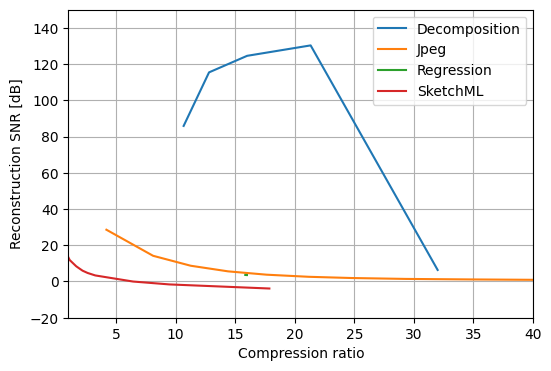

In [21]:
plt.figure(figsize=(6,4))
plt.plot(lowrank_decomposition_ratio, lowrank_decomposition_snr,label ="Decomposition")
plt.plot(lowrank_jpeg_ratio, lowrank_jpeg_snr,label ="Jpeg")
plt.plot(lowrank_regression_ratio, lowrank_regression_snr,label ="Regression")
plt.plot(lowrank_sketchml_ratio, lowrank_sketchml_snr,label ="SketchML")
plt.legend()
plt.grid()
plt.ylim([-20,150])
plt.autoscale(axis='x',tight=True)
plt.xlabel("Compression ratio")
plt.ylabel("Reconstruction SNR [dB]")

# Plotting